In [15]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.preprocessing.image import *
import keras.backend as K
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

# 20.3.1)

In [16]:
data = pd.DataFrame(columns=["path", "label"])
i = 0
prog = 1
sys.stdout.write("[" + " " * 20 + "]\r")
sys.stdout.flush()
for root, dirs, files in os.walk("data/train/"):
    prt = len(files) / 20
    for file in files:
        data = data.append({"path": f"{root}{file}", "label": file.split(".")[0]}, ignore_index=True)
        i += 1
        if (i >= prt*prog):
            sys.stdout.write("[" + "=" * prog + "\r")
            sys.stdout.flush()
            prog += 1
    sys.stdout.write("\n")
    sys.stdout.flush()
print(f"done, {i} files")

[====================]
done, 25000 files


In [17]:
data.head()

path label
0     data/train/cat.0.jpg   cat
1     data/train/cat.1.jpg   cat
2    data/train/cat.10.jpg   cat
3   data/train/cat.100.jpg   cat
4  data/train/cat.1000.jpg   cat

# 20.3.2)

In [18]:
data.shape

(25000, 2)

In [19]:
data["label"].describe()

count     25000
unique        2
top         cat
freq      12500
Name: label, dtype: object

# 20.3.3)

In [20]:
def show_image(path):
    plt.imshow(load_img(path))

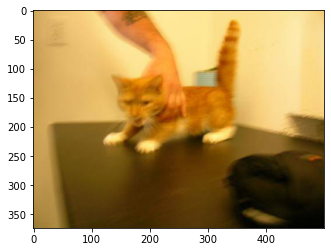

In [21]:
show_image("data/train/cat.0.jpg")

# 20.3.4)

In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
data["path"] = data.apply(lambda x: x["path"].split("/")[-1], axis=1)

In [24]:
train_df, validation_df = train_test_split(data, test_size=0.20, random_state=12)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
print(train_df.shape)
print(validation_df.shape)

(20000, 2)
(5000, 2)


In [25]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "data/train",
    x_col = "path",
    y_col = "label",
    target_size = (150,150),
    batch_size = 200,
    class_mode = "categorical"
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    directory = "data/train",
    x_col = "path",
    y_col = "label",
    target_size = (150,150),
    batch_size = 200,
    class_mode = "categorical"
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [26]:
for data_batch, labels_batch in train_generator:
    print(data_batch.shape)
    print(labels_batch.shape)
    break

(200, 150, 150, 3)
(200, 2)


In [27]:
history = model.fit( train_generator, steps_per_epoch = 100, validation_data = validation_generator, epochs=10)

Epoch 1/10
100/100 [==============================] - 485s 5s/step - loss: 0.8034 - accuracy: 0.5333 - val_loss: 1.0350 - val_accuracy: 0.4934
Epoch 2/10
100/100 [==============================] - 384s 4s/step - loss: 0.6757 - accuracy: 0.6012 - val_loss: 0.6224 - val_accuracy: 0.6358
Epoch 3/10
100/100 [==============================] - 393s 4s/step - loss: 0.6067 - accuracy: 0.6772 - val_loss: 0.5152 - val_accuracy: 0.7468
Epoch 4/10
100/100 [==============================] - 361s 4s/step - loss: 0.5568 - accuracy: 0.7203 - val_loss: 0.5931 - val_accuracy: 0.6512
Epoch 5/10
100/100 [==============================] - 383s 4s/step - loss: 0.4890 - accuracy: 0.7631 - val_loss: 0.6322 - val_accuracy: 0.6632
Epoch 6/10
100/100 [==============================] - 341s 3s/step - loss: 0.4312 - accuracy: 0.7966 - val_loss: 0.4299 - val_accuracy: 0.8052
Epoch 7/10
100/100 [==============================] - 373s 4s/step - loss: 0.3871 - accuracy: 0.8238 - val_loss: 0.3523 - val_accuracy: 0.8432

# 20.3.5)

In [29]:
test_filenames = os.listdir("data/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
test_df.shape[0]

12500

In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    directory="data/test",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(150,150),
    batch_size=32,
    shuffle=False
)

Found 12500 validated image filenames.


In [31]:
test_generator.reset()
pred=model.predict(test_generator, verbose=1)

391/391 [==============================] - 150s 385ms/step


In [32]:
pred

array([[0.01130288, 0.9886972 ],
       [0.9987233 , 0.00127664],
       [0.47595054, 0.52404946],
       ...,
       [0.17529102, 0.82470894],
       [0.9977471 , 0.00225291],
       [0.8495013 , 0.15049866]], dtype=float32)

In [33]:
pred_rounded = np.argmax(pred, axis=-1)
test_df["category"] = pred_rounded
test_df["category"] = test_df["category"].map({0: 'cat', 1: 'dog'})
test_df.head(10)

filename category
0      1.jpg      dog
1     10.jpg      cat
2    100.jpg      dog
3   1000.jpg      dog
4  10000.jpg      dog
5  10001.jpg      cat
6  10002.jpg      cat
7  10003.jpg      dog
8  10004.jpg      cat
9  10005.jpg      cat

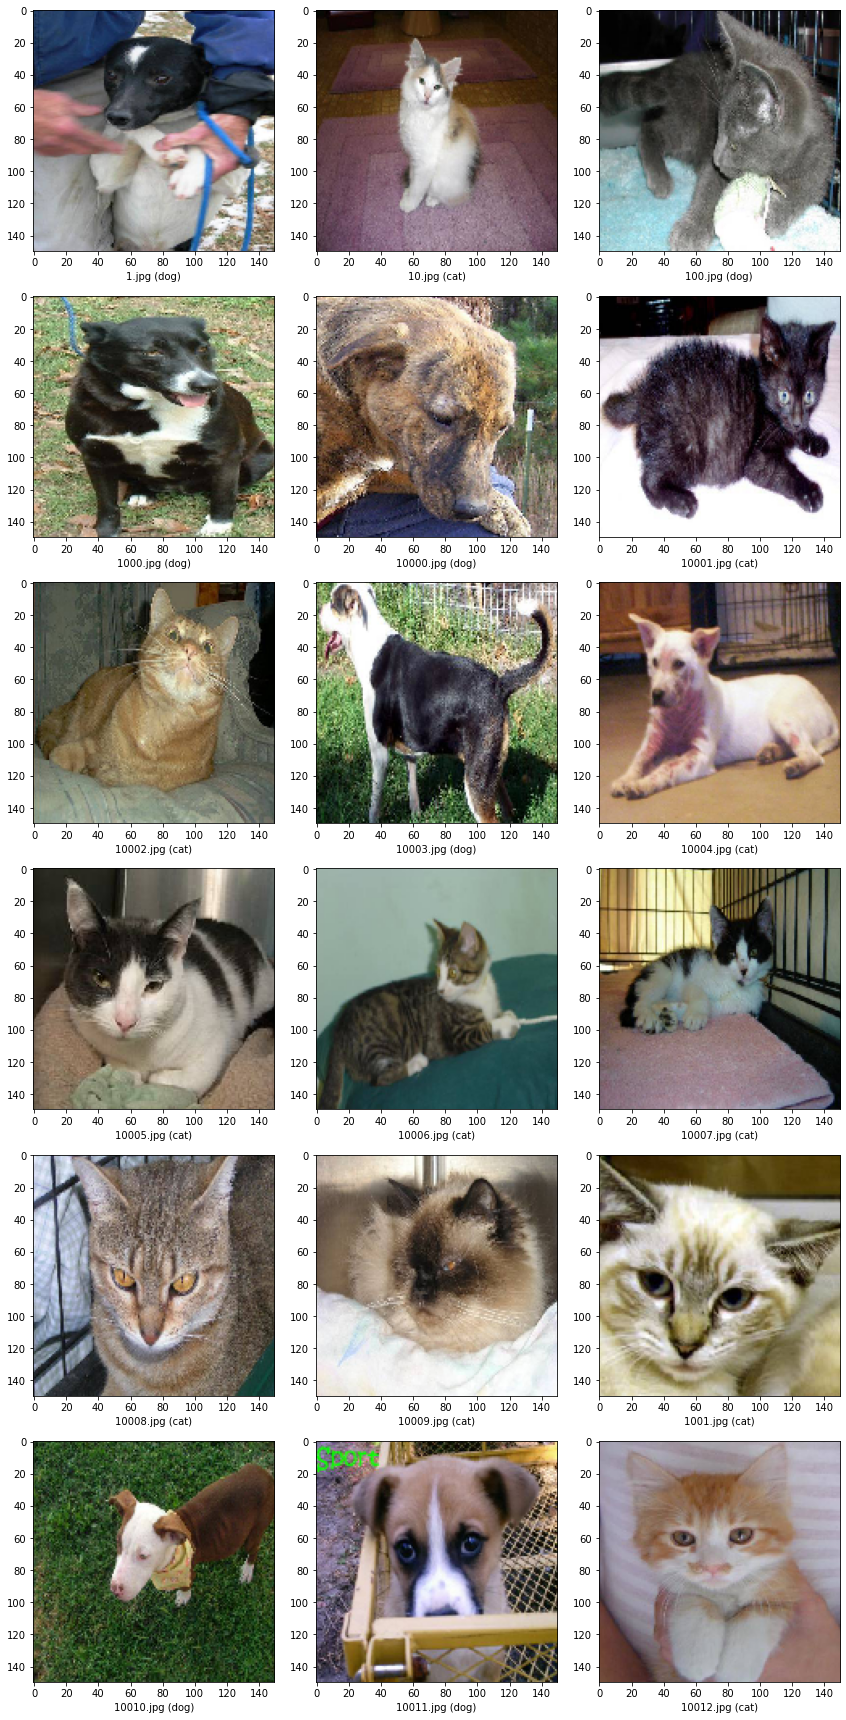

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/test/"+filename, target_size=(150,150))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(f"{filename} ({category})")
plt.tight_layout()
plt.show()

In [36]:
model.save("model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model\assets
